In [1]:
%run ./Definitions.ipynb
!nvidia-smi
import os

2019-12-22 16:31:58.039743
thunder  Sun Dec 22 16:31:58 2019
[0] GeForce GTX 1080 Ti | 49'C,   0 % | 10895 / 11178 MB | patra(10885M)
[1] GeForce GTX 1080 Ti | 26'C,   0 % |    10 / 11178 MB |
[2] GeForce GTX 1080 Ti | 27'C,   0 % |    10 / 11178 MB |
[3] GeForce GTX 1080 Ti | 25'C,   0 % |    10 / 11178 MB |
[4] GeForce GTX 1080 Ti | 24'C,   0 % |    10 / 11178 MB |
[5] GeForce GTX 1080 Ti | 28'C,   0 % | 10895 / 11178 MB | michiel(10885M)
[6] GeForce GTX 1080 Ti | 53'C,  42 % | 10895 / 11178 MB | michiel(10885M)
[7] GeForce GTX 1080 Ti | 28'C,   0 % |    10 / 11178 MB |


/ds/environments/python2020/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
/ds/environments/python2020/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Dataset consist of 85730 patients data with 6251 features for each patient
Function definitions executed
Definitions DONE !!

Sun Dec 22 16:32:10 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 34%   50C    P2    82W / 250W |  10895MiB / 11178MiB |     24%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 29%   26C    P8     7W / 250W |     10Mi

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "1"   # choose here your GPU (0-7)

import tensorflow as tf
import tensorflow.compat.v1 as tf
import keras
# from keras import backend as K
import tensorflow.python.keras.backend as K

# config = tf.ConfigProto()
# config.gpu_options.allow_growth=True
# sess = tf.Session(config=config)
# K.set_session(sess)

In [3]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

### LOAD valid train test and validation image names 

In [4]:
valid_traindf_names = pd.read_pickle(funduspath_CR + 'valid_traindf_names.pkl')
valid_valdf_names = pd.read_pickle(funduspath_CR + 'valid_valdf_names.pkl')
valid_testdf_names = pd.read_pickle(funduspath_CR + 'valid_testdf_names.pkl')

valid_traindf_names.shape , valid_valdf_names.shape , valid_testdf_names.shape

((101834, 5), (33943, 5), (33936, 5))

In [5]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

## Handling Imbalanced Data sets

In [6]:
which_gt = 4 # CHANGE 1,2,3,4 implies 'GT523', 'GT19', 'GTi', 'GTu'
n_NG = 0 # non glaucoma
n_G = 0  # glaucoma

GT_dict = {1:'GT523',2:'GT19',3:'GTi',4:'GTu'}
Class = GT_dict[which_gt]
temp = valid_traindf_names[Class]
for i in range(len(temp)):
    if(temp[i] == '1'):
        n_G += 1
    else:
        n_NG += 1
        
print("No. of Glaucoma patients in training set:",n_G)
print("No. of non-Glaucoma patients in training set:",n_NG)

No. of Glaucoma patients in training set: 2379
No. of non-Glaucoma patients in training set: 99455


### 1. Over Sampling Train set

In [7]:
# Oversample the minority class

X_train = valid_traindf_names['Fundus_Filenames']
y_train = valid_traindf_names[GT_dict[which_gt]]

# Converting class values to int 1 or 0
y_train = y_train.astype(int)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_glaucoma = X[X[Class]==0]
glaucoma = X[X[Class]==1]

# upsample minority
glaucoma_upsampled = resample(glaucoma,
                              replace=True, # sample with replacement
                              n_samples=len(not_glaucoma), # match number in majority class
                              random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_glaucoma,glaucoma_upsampled])

# shuffle upsampled dataframe for training
upsampled = upsampled.sample(frac=1)


In [8]:
X[Class].value_counts()

0    99455
1     2379
Name: GTu, dtype: int64

In [9]:
upsampled[Class].value_counts()

1    99455
0    99455
Name: GTu, dtype: int64

#### validation distribution

In [10]:
valid_valdf_names[Class].value_counts()

0    33134
1      809
Name: GTu, dtype: int64

### Oversampling minority with less imbalance - in train set
Original imbalance ratio **X-** 1:40

Imbalance ratio **up1**-1:5, **up2**-1:10, **up3**-1:20, **up4**-1:30

Balanced ratio **upsampled**-1:1

In [11]:
# upsampling minority
glaucoma_up1 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/5), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up2 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/10), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up3 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/20), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up4 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/30), # match number in majority class
                        random_state=42) # reproducible results

# combine majority and upsampled minority
up1 = pd.concat([not_glaucoma,glaucoma_up1])
up2 = pd.concat([not_glaucoma,glaucoma_up2])
up3 = pd.concat([not_glaucoma,glaucoma_up3])
up4 = pd.concat([not_glaucoma,glaucoma_up4])

# shuffle upsampled dataframe for training
up1 = up1.sample(frac=1)
up2 = up2.sample(frac=1)
up3 = up3.sample(frac=1)
up4 = up4.sample(frac=1)


In [12]:
print("up1")
print(up1[Class].value_counts())
print("up2")
print(up2[Class].value_counts())
print("up1")
print(up3[Class].value_counts())
print("up4")
print(up4[Class].value_counts())

up1
0    99455
1    19891
Name: GTu, dtype: int64
up2
0    99455
1     9945
Name: GTu, dtype: int64
up1
0    99455
1     4972
Name: GTu, dtype: int64
up4
0    99455
1     3315
Name: GTu, dtype: int64


### 2. Class weight

In [13]:
# Setting class weight for retraining:

# compute_class_weight('balanced', np.unique(y_train), y_train)
class_weight = [0.5, 2] # experiment with different values
n_NG , n_G , class_weight

(99455, 2379, [0.5, 2])

## Define Model and Metrics

In [14]:
# reg_values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6] # 1e-1, 
reg_value = 0.001
METRICS = [keras.metrics.BinaryAccuracy(name='Accuracy'),
           Precision, 
           Recall, 
           F1,
           keras.metrics.AUC(name='AUC')]

def mobilenet_model():       
    mobile_conv = MobileNet(weights='imagenet', include_top=False, input_shape=(red_size, red_size, 3))

    # UnFreeze last conv layer
    for layer in mobile_conv.layers[:84]:
        layer.trainable = False
    for layer in mobile_conv.layers[84:]:
        layer.trainable = True
        
    # Create the model
    model = models.Sequential()
    model.add(mobile_conv)
 
    # Add new layers
    # https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1, activation='sigmoid'))
 
    return model

### Augmentation
https://nbviewer.jupyter.org/github/aleju/imgaug-doc/blob/master/notebooks/A01%20-%20Load%20and%20Augment%20an%20Image.ipynb

In [15]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(scale=1.1),
    iaa.Affine(rotate=(-10, 10)),
    # iaa.GammaContrast(0.9),
    iaa.Resize({"height": 230, "width": 230}),
    iaa.CropToFixedSize(width=red_size, height=red_size)
    ])

### Flow from Dataframe
https://www.kaggle.com/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe

In [16]:
valid_traindf_names[Class] = valid_traindf_names[Class].astype(int)
valid_valdf_names[Class] = valid_valdf_names[Class].astype(int)

In [17]:
# To use same settings as mobilenet
# from keras.applications.mobilenet import preprocess_input
# train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function=seq.augment_image, samplewise_center=True, rescale= 1./255) 
val_datagen = ImageDataGenerator(samplewise_center=True, rescale=1./255)  
BATCH_SIZE = 32

print("\nOriginal imbalanced train data: ")
imb_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = valid_traindf_names, # imbalanced train dataframe
    directory=trainpath,
    x_col=valid_traindf_names.columns[0],
    y_col=valid_traindf_names.columns[which_gt],
#     x_col = upsampled.columns[0], # upsampled data
#     y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nOriginal validation data: ")
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=valid_valdf_names,
    directory=valpath,
    x_col=valid_valdf_names.columns[0],
    y_col=valid_valdf_names.columns[which_gt],
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUpsampled train data 1:1 ")
up_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = upsampled, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = upsampled.columns[0], # upsampled data
    y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP1 train data 1:5 ")
up1_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up1, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up1.columns[0], # upsampled data
    y_col = up1.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP2 train data 1:10 ")
up2_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up2, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up2.columns[0], # upsampled data
    y_col = up2.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP3 train data 1:20 ")
up3_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up3, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up3.columns[0], # upsampled data
    y_col = up3.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP4 train data 1:30 ")
up4_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up4, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up4.columns[0], # upsampled data
    y_col = up4.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)



Original imbalanced train data: 
Found 101834 validated image filenames.

Original validation data: 
Found 33943 validated image filenames.

Upsampled train data 1:1 
Found 198910 validated image filenames.

UP1 train data 1:5 
Found 119346 validated image filenames.

UP2 train data 1:10 
Found 109400 validated image filenames.

UP3 train data 1:20 
Found 104427 validated image filenames.

UP4 train data 1:30 
Found 102770 validated image filenames.


### Choosing parameters and model compile

In [18]:
which_model = mobilenet_model
# which_model = vgg_model

model = which_model()
learning_rate  = 0.0001 
decay = 1e-5
momentum=0.9
opt = Adam(lr=learning_rate, decay = decay) 
model.compile(loss='binary_crossentropy', metrics=METRICS, optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 1,051,649
Non-trainable params: 2,178,240
_________________________________________________________________


In [19]:
# With L2 weight regularizer
# es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.000001, verbose=1)
n_epochs=200
n_steps_per_epoch = 50
n_validation_steps = 10

### Train with upsampled data (1:1)

In [20]:
start = time.time()
up_history = model.fit_generator(up_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              callbacks=[reduce_lr]
                             )
end = time.time()

/ds/environments/python2020/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):


Epoch 1/200
50/50 [==============================] - 23s 460ms/step - loss: 0.7146 - Accuracy: 0.5669 - Precision: 0.5626 - Recall: 0.6155 - F1: 0.5736 - AUC: 0.5932 - val_loss: 1.3923 - val_Accuracy: 0.0281 - val_Precision: 0.0221 - val_Recall: 0.6000 - val_F1: 0.0424 - val_AUC: 0.4607
Epoch 2/200
50/50 [==============================] - 21s 422ms/step - loss: 0.6613 - Accuracy: 0.6119 - Precision: 0.6029 - Recall: 0.5928 - F1: 0.5894 - AUC: 0.6688 - val_loss: 1.9457 - val_Accuracy: 0.0156 - val_Precision: 0.0156 - val_Recall: 0.3000 - val_F1: 0.0293 - val_AUC: 0.5098
Epoch 3/200
50/50 [==============================] - 22s 445ms/step - loss: 0.6440 - Accuracy: 0.6425 - Precision: 0.6432 - Recall: 0.6679 - F1: 0.6439 - AUC: 0.6887 - val_loss: 1.6169 - val_Accuracy: 0.0156 - val_Precision: 0.0063 - val_Recall: 0.2000 - val_F1: 0.0121 - val_AUC: 0.5079
Epoch 4/200
50/50 [==============================] - 23s 456ms/step - loss: 0.6744 - Accuracy: 0.6094 - Precision: 0.6183 - Recall: 0.62

Epoch 29/200
50/50 [==============================] - 22s 443ms/step - loss: 0.6034 - Accuracy: 0.6719 - Precision: 0.6751 - Recall: 0.6954 - F1: 0.6785 - AUC: 0.7360 - val_loss: 1.5181 - val_Accuracy: 0.0625 - val_Precision: 0.0235 - val_Recall: 0.5000 - val_F1: 0.0446 - val_AUC: 0.4966
Epoch 30/200
50/50 [==============================] - 22s 441ms/step - loss: 0.6031 - Accuracy: 0.6675 - Precision: 0.6732 - Recall: 0.6912 - F1: 0.6769 - AUC: 0.7335 - val_loss: 1.4903 - val_Accuracy: 0.0344 - val_Precision: 0.0099 - val_Recall: 0.3000 - val_F1: 0.0192 - val_AUC: 0.4716
Epoch 31/200
50/50 [==============================] - 23s 456ms/step - loss: 0.6113 - Accuracy: 0.6750 - Precision: 0.6726 - Recall: 0.7010 - F1: 0.6800 - AUC: 0.7264 - val_loss: 1.5024 - val_Accuracy: 0.0375 - val_Precision: 0.0284 - val_Recall: 0.7000 - val_F1: 0.0540 - val_AUC: 0.5413
Epoch 32/200
50/50 [==============================] - 22s 431ms/step - loss: 0.5841 - Accuracy: 0.6969 - Precision: 0.6807 - Recall: 

50/50 [==============================] - 22s 447ms/step - loss: 0.5942 - Accuracy: 0.6756 - Precision: 0.6633 - Recall: 0.6956 - F1: 0.6736 - AUC: 0.7444 - val_loss: 1.4029 - val_Accuracy: 0.0562 - val_Precision: 0.0318 - val_Recall: 0.7000 - val_F1: 0.0601 - val_AUC: 0.5461
Epoch 58/200
50/50 [==============================] - 22s 441ms/step - loss: 0.6004 - Accuracy: 0.6787 - Precision: 0.6829 - Recall: 0.7081 - F1: 0.6875 - AUC: 0.7372 - val_loss: 1.3981 - val_Accuracy: 0.0625 - val_Precision: 0.0293 - val_Recall: 0.6000 - val_F1: 0.0551 - val_AUC: 0.5155
Epoch 59/200
50/50 [==============================] - 24s 477ms/step - loss: 0.5896 - Accuracy: 0.6875 - Precision: 0.6858 - Recall: 0.7128 - F1: 0.6922 - AUC: 0.7507 - val_loss: 1.4326 - val_Accuracy: 0.0250 - val_Precision: 0.0095 - val_Recall: 0.3000 - val_F1: 0.0184 - val_AUC: 0.6598
Epoch 60/200
50/50 [==============================] - 22s 437ms/step - loss: 0.5793 - Accuracy: 0.6944 - Precision: 0.6829 - Recall: 0.7293 - F1: 

50/50 [==============================] - 24s 480ms/step - loss: 0.5880 - Accuracy: 0.6856 - Precision: 0.6846 - Recall: 0.7062 - F1: 0.6894 - AUC: 0.7499 - val_loss: 1.4385 - val_Accuracy: 0.0437 - val_Precision: 0.0259 - val_Recall: 0.6000 - val_F1: 0.0491 - val_AUC: 0.6316
Epoch 86/200
50/50 [==============================] - 23s 456ms/step - loss: 0.5754 - Accuracy: 0.7081 - Precision: 0.6903 - Recall: 0.7354 - F1: 0.7041 - AUC: 0.7723 - val_loss: 1.4247 - val_Accuracy: 0.0625 - val_Precision: 0.0229 - val_Recall: 0.5000 - val_F1: 0.0436 - val_AUC: 0.6273
Epoch 87/200
50/50 [==============================] - 23s 460ms/step - loss: 0.5930 - Accuracy: 0.6819 - Precision: 0.6459 - Recall: 0.7056 - F1: 0.6682 - AUC: 0.7471 - val_loss: 1.4191 - val_Accuracy: 0.0469 - val_Precision: 0.0252 - val_Recall: 0.6000 - val_F1: 0.0478 - val_AUC: 0.5775
Epoch 88/200
50/50 [==============================] - 24s 479ms/step - loss: 0.5651 - Accuracy: 0.7094 - Precision: 0.6998 - Recall: 0.7321 - F1: 

50/50 [==============================] - 23s 455ms/step - loss: 0.5813 - Accuracy: 0.6913 - Precision: 0.6790 - Recall: 0.7297 - F1: 0.6980 - AUC: 0.7589 - val_loss: 1.5148 - val_Accuracy: 0.0688 - val_Precision: 0.0323 - val_Recall: 0.6000 - val_F1: 0.0610 - val_AUC: 0.7215
Epoch 114/200
50/50 [==============================] - 23s 463ms/step - loss: 0.5873 - Accuracy: 0.6931 - Precision: 0.6963 - Recall: 0.7012 - F1: 0.6931 - AUC: 0.7543 - val_loss: 1.5226 - val_Accuracy: 0.0500 - val_Precision: 0.0289 - val_Recall: 0.6000 - val_F1: 0.0539 - val_AUC: 0.6024
Epoch 115/200
50/50 [==============================] - 23s 460ms/step - loss: 0.5851 - Accuracy: 0.6781 - Precision: 0.6532 - Recall: 0.7099 - F1: 0.6742 - AUC: 0.7531 - val_loss: 1.3181 - val_Accuracy: 0.0469 - val_Precision: 0.0097 - val_Recall: 0.3000 - val_F1: 0.0188 - val_AUC: 0.6314
Epoch 116/200
50/50 [==============================] - 24s 474ms/step - loss: 0.5877 - Accuracy: 0.6969 - Precision: 0.7009 - Recall: 0.7067 - F

50/50 [==============================] - 23s 456ms/step - loss: 0.5661 - Accuracy: 0.7056 - Precision: 0.6966 - Recall: 0.7313 - F1: 0.7076 - AUC: 0.7807 - val_loss: 1.5472 - val_Accuracy: 0.0562 - val_Precision: 0.0322 - val_Recall: 0.5000 - val_F1: 0.0594 - val_AUC: 0.6229
Epoch 142/200
50/50 [==============================] - 24s 476ms/step - loss: 0.5756 - Accuracy: 0.7069 - Precision: 0.6994 - Recall: 0.7359 - F1: 0.7096 - AUC: 0.7683 - val_loss: 1.5817 - val_Accuracy: 0.0437 - val_Precision: 0.0099 - val_Recall: 0.3000 - val_F1: 0.0192 - val_AUC: 0.5431
Epoch 143/200
50/50 [==============================] - 23s 454ms/step - loss: 0.5725 - Accuracy: 0.7000 - Precision: 0.7026 - Recall: 0.7272 - F1: 0.7100 - AUC: 0.7704 - val_loss: 1.4020 - val_Accuracy: 0.0781 - val_Precision: 0.0265 - val_Recall: 0.7000 - val_F1: 0.0509 - val_AUC: 0.4990
Epoch 144/200
50/50 [==============================] - 23s 453ms/step - loss: 0.5810 - Accuracy: 0.7019 - Precision: 0.6993 - Recall: 0.7269 - F

50/50 [==============================] - 22s 441ms/step - loss: 0.5677 - Accuracy: 0.7113 - Precision: 0.6841 - Recall: 0.7556 - F1: 0.7126 - AUC: 0.7770 - val_loss: 1.4736 - val_Accuracy: 0.0656 - val_Precision: 0.0234 - val_Recall: 0.6000 - val_F1: 0.0449 - val_AUC: 0.5030
Epoch 170/200
50/50 [==============================] - 23s 454ms/step - loss: 0.5956 - Accuracy: 0.6825 - Precision: 0.6868 - Recall: 0.6855 - F1: 0.6808 - AUC: 0.7461 - val_loss: 1.3348 - val_Accuracy: 0.0469 - val_Precision: 0.0192 - val_Recall: 0.4000 - val_F1: 0.0364 - val_AUC: 0.5987
Epoch 171/200
50/50 [==============================] - 23s 462ms/step - loss: 0.5980 - Accuracy: 0.6769 - Precision: 0.6689 - Recall: 0.6979 - F1: 0.6768 - AUC: 0.7449 - val_loss: 1.2919 - val_Accuracy: 0.0688 - val_Precision: 0.0166 - val_Recall: 0.3500 - val_F1: 0.0315 - val_AUC: 0.4108
Epoch 172/200
50/50 [==============================] - 23s 457ms/step - loss: 0.5743 - Accuracy: 0.7000 - Precision: 0.6772 - Recall: 0.7380 - F

50/50 [==============================] - 24s 477ms/step - loss: 0.5731 - Accuracy: 0.7063 - Precision: 0.6961 - Recall: 0.7292 - F1: 0.7055 - AUC: 0.7723 - val_loss: 1.4851 - val_Accuracy: 0.0562 - val_Precision: 0.0227 - val_Recall: 0.3500 - val_F1: 0.0423 - val_AUC: 0.4243
Epoch 198/200
50/50 [==============================] - 23s 455ms/step - loss: 0.5860 - Accuracy: 0.6819 - Precision: 0.6917 - Recall: 0.6935 - F1: 0.6859 - AUC: 0.7530 - val_loss: 1.4977 - val_Accuracy: 0.0625 - val_Precision: 0.0225 - val_Recall: 0.6000 - val_F1: 0.0432 - val_AUC: 0.4690
Epoch 199/200
50/50 [==============================] - 23s 450ms/step - loss: 0.5682 - Accuracy: 0.7081 - Precision: 0.7021 - Recall: 0.7258 - F1: 0.7075 - AUC: 0.7746 - val_loss: 1.3978 - val_Accuracy: 0.0562 - val_Precision: 0.0288 - val_Recall: 0.5000 - val_F1: 0.0534 - val_AUC: 0.6629
Epoch 200/200
50/50 [==============================] - 23s 468ms/step - loss: 0.5827 - Accuracy: 0.6963 - Precision: 0.6898 - Recall: 0.7139 - F

In [21]:
print("Time taken:",end-start)

Time taken: 4555.282777070999


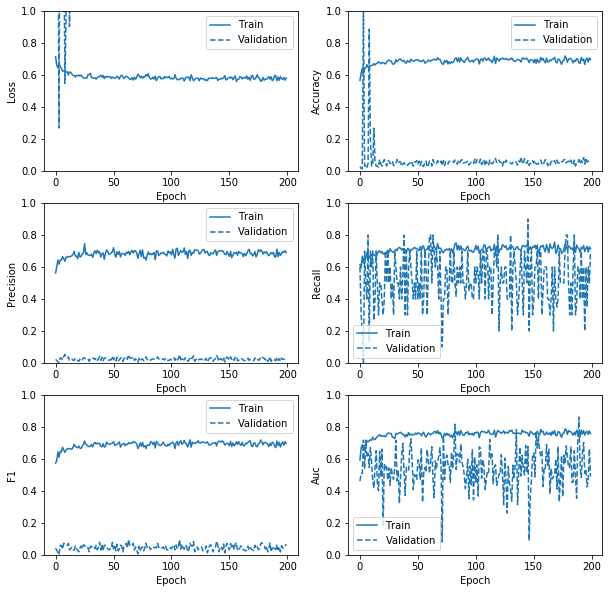

In [22]:
plt.figure(figsize=(10,10))
plot_metrics(up_history)

### Train with UP2 (1:10)

In [23]:
start = time.time()
up2_history = model.fit_generator(up2_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              callbacks=[reduce_lr]
                             )
end = time.time()

Epoch 1/200
50/50 [==============================] - 22s 431ms/step - loss: 0.6843 - Accuracy: 0.5700 - Precision: 0.1605 - Recall: 0.7520 - F1: 0.2559 - AUC: 0.7820 - val_loss: 1.5703 - val_Accuracy: 0.0562 - val_Precision: 0.0289 - val_Recall: 0.7000 - val_F1: 0.0552 - val_AUC: 0.5545
Epoch 2/200
50/50 [==============================] - 22s 446ms/step - loss: 0.6612 - Accuracy: 0.6037 - Precision: 0.1444 - Recall: 0.6877 - F1: 0.2311 - AUC: 0.7538 - val_loss: 1.3218 - val_Accuracy: 0.0812 - val_Precision: 0.0544 - val_Recall: 0.7000 - val_F1: 0.0996 - val_AUC: 0.5265
Epoch 3/200
50/50 [==============================] - 20s 397ms/step - loss: 0.6253 - Accuracy: 0.6569 - Precision: 0.1784 - Recall: 0.7568 - F1: 0.2781 - AUC: 0.7906 - val_loss: 1.4881 - val_Accuracy: 0.0375 - val_Precision: 0.0127 - val_Recall: 0.4000 - val_F1: 0.0246 - val_AUC: 0.6381
Epoch 4/200
50/50 [==============================] - 21s 411ms/step - loss: 0.5992 - Accuracy: 0.6731 - Precision: 0.1915 - Recall: 0.74

50/50 [==============================] - 20s 405ms/step - loss: 0.3739 - Accuracy: 0.8706 - Precision: 0.3133 - Recall: 0.2655 - F1: 0.2636 - AUC: 0.7658 - val_loss: 1.2246 - val_Accuracy: 0.1187 - val_Precision: 0.0344 - val_Recall: 0.6000 - val_F1: 0.0644 - val_AUC: 0.5958
Epoch 30/200
50/50 [==============================] - 21s 420ms/step - loss: 0.3595 - Accuracy: 0.8813 - Precision: 0.3087 - Recall: 0.2497 - F1: 0.2531 - AUC: 0.7851 - val_loss: 1.1572 - val_Accuracy: 0.1250 - val_Precision: 0.0170 - val_Recall: 0.4000 - val_F1: 0.0325 - val_AUC: 0.7225
Epoch 31/200
50/50 [==============================] - 22s 434ms/step - loss: 0.3625 - Accuracy: 0.8825 - Precision: 0.3437 - Recall: 0.2653 - F1: 0.2719 - AUC: 0.7500 - val_loss: 1.0303 - val_Accuracy: 0.1281 - val_Precision: 0.0067 - val_Recall: 0.2000 - val_F1: 0.0129 - val_AUC: 0.3188
Epoch 32/200
50/50 [==============================] - 20s 410ms/step - loss: 0.3610 - Accuracy: 0.8844 - Precision: 0.2740 - Recall: 0.2024 - F1: 

50/50 [==============================] - 21s 414ms/step - loss: 0.2985 - Accuracy: 0.9025 - Precision: 0.1300 - Recall: 0.0642 - F1: 0.0744 - AUC: 0.7684 - val_loss: 0.8640 - val_Accuracy: 0.2906 - val_Precision: 0.0153 - val_Recall: 0.3000 - val_F1: 0.0289 - val_AUC: 0.4666
Epoch 58/200
50/50 [==============================] - 20s 406ms/step - loss: 0.3029 - Accuracy: 0.9038 - Precision: 0.1500 - Recall: 0.0403 - F1: 0.0627 - AUC: 0.7520 - val_loss: 0.8459 - val_Accuracy: 0.3219 - val_Precision: 0.0231 - val_Recall: 0.3500 - val_F1: 0.0432 - val_AUC: 0.6022
Epoch 59/200
50/50 [==============================] - 21s 420ms/step - loss: 0.2993 - Accuracy: 0.9006 - Precision: 0.0833 - Recall: 0.0413 - F1: 0.0517 - AUC: 0.7624 - val_loss: 0.8503 - val_Accuracy: 0.3156 - val_Precision: 0.0095 - val_Recall: 0.2000 - val_F1: 0.0182 - val_AUC: 0.3904
Epoch 60/200
50/50 [==============================] - 21s 417ms/step - loss: 0.2972 - Accuracy: 0.9056 - Precision: 0.2500 - Recall: 0.0963 - F1: 

50/50 [==============================] - 21s 421ms/step - loss: 0.2636 - Accuracy: 0.9162 - Precision: 0.1300 - Recall: 0.0867 - F1: 0.0924 - AUC: 0.7867 - val_loss: 0.6980 - val_Accuracy: 0.5188 - val_Precision: 0.0103 - val_Recall: 0.2000 - val_F1: 0.0195 - val_AUC: 0.4794
Epoch 86/200
50/50 [==============================] - 20s 394ms/step - loss: 0.2667 - Accuracy: 0.9119 - Precision: 0.1000 - Recall: 0.0317 - F1: 0.0480 - AUC: 0.7855 - val_loss: 0.6882 - val_Accuracy: 0.5031 - val_Precision: 0.0220 - val_Recall: 0.1400 - val_F1: 0.0353 - val_AUC: 0.4565
Epoch 87/200
50/50 [==============================] - 20s 408ms/step - loss: 0.2620 - Accuracy: 0.9175 - Precision: 0.1100 - Recall: 0.0340 - F1: 0.0508 - AUC: 0.7582 - val_loss: 0.6974 - val_Accuracy: 0.5125 - val_Precision: 0.0266 - val_Recall: 0.2833 - val_F1: 0.0477 - val_AUC: 0.5779
Epoch 88/200
50/50 [==============================] - 22s 436ms/step - loss: 0.2700 - Accuracy: 0.9150 - Precision: 0.0400 - Recall: 0.0173 - F1: 

50/50 [==============================] - 20s 407ms/step - loss: 0.2777 - Accuracy: 0.9100 - Precision: 0.0200 - Recall: 0.0200 - F1: 0.0200 - AUC: 0.7145 - val_loss: 0.5683 - val_Accuracy: 0.6656 - val_Precision: 0.0383 - val_Recall: 0.3500 - val_F1: 0.0684 - val_AUC: 0.5753
Epoch 114/200
50/50 [==============================] - 21s 417ms/step - loss: 0.2636 - Accuracy: 0.9094 - Precision: 0.0200 - Recall: 0.0050 - F1: 0.0080 - AUC: 0.7797 - val_loss: 0.5903 - val_Accuracy: 0.6406 - val_Precision: 0.0247 - val_Recall: 0.2500 - val_F1: 0.0444 - val_AUC: 0.4194
Epoch 115/200
50/50 [==============================] - 21s 413ms/step - loss: 0.2503 - Accuracy: 0.9169 - Precision: 0.0200 - Recall: 0.0067 - F1: 0.0100 - AUC: 0.7755 - val_loss: 0.5747 - val_Accuracy: 0.6125 - val_Precision: 0.0229 - val_Recall: 0.2333 - val_F1: 0.0409 - val_AUC: 0.6016
Epoch 116/200
50/50 [==============================] - 20s 401ms/step - loss: 0.2679 - Accuracy: 0.9044 - Precision: 0.0600 - Recall: 0.0147 - F

50/50 [==============================] - 21s 422ms/step - loss: 0.2782 - Accuracy: 0.9062 - Precision: 0.0600 - Recall: 0.0250 - F1: 0.0347 - AUC: 0.7400 - val_loss: 0.6246 - val_Accuracy: 0.7812 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5055
Epoch 142/200
50/50 [==============================] - 20s 399ms/step - loss: 0.2581 - Accuracy: 0.9137 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7630 - val_loss: 0.5411 - val_Accuracy: 0.7625 - val_Precision: 0.0091 - val_Recall: 0.1000 - val_F1: 0.0167 - val_AUC: 0.5219
Epoch 143/200
50/50 [==============================] - 21s 415ms/step - loss: 0.2501 - Accuracy: 0.9156 - Precision: 0.0200 - Recall: 0.0040 - F1: 0.0067 - AUC: 0.7916 - val_loss: 0.6238 - val_Accuracy: 0.7469 - val_Precision: 0.0111 - val_Recall: 0.1000 - val_F1: 0.0200 - val_AUC: 0.4915
Epoch 144/200
50/50 [==============================] - 21s 411ms/step - loss: 0.2828 - Accuracy: 0.8975 - Precision: 0.0

Epoch 169/200
50/50 [==============================] - 21s 418ms/step - loss: 0.2819 - Accuracy: 0.9006 - Precision: 0.0200 - Recall: 0.0067 - F1: 0.0100 - AUC: 0.7645 - val_loss: 0.5640 - val_Accuracy: 0.7906 - val_Precision: 0.0236 - val_Recall: 0.2000 - val_F1: 0.0422 - val_AUC: 0.6180
Epoch 170/200
50/50 [==============================] - 21s 422ms/step - loss: 0.2833 - Accuracy: 0.8988 - Precision: 0.0600 - Recall: 0.0109 - F1: 0.0183 - AUC: 0.7789 - val_loss: 0.4886 - val_Accuracy: 0.8000 - val_Precision: 0.0143 - val_Recall: 0.0500 - val_F1: 0.0222 - val_AUC: 0.5794
Epoch 171/200
50/50 [==============================] - 19s 386ms/step - loss: 0.2574 - Accuracy: 0.9150 - Precision: 0.0500 - Recall: 0.0173 - F1: 0.0257 - AUC: 0.7487 - val_loss: 0.5503 - val_Accuracy: 0.7969 - val_Precision: 0.0143 - val_Recall: 0.1000 - val_F1: 0.0250 - val_AUC: 0.5368
Epoch 172/200
50/50 [==============================] - 20s 405ms/step - loss: 0.2627 - Accuracy: 0.9044 - Precision: 0.0000e+00 - 

Epoch 197/200
50/50 [==============================] - 21s 415ms/step - loss: 0.2757 - Accuracy: 0.9087 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7418 - val_loss: 0.4800 - val_Accuracy: 0.8406 - val_Precision: 0.0333 - val_Recall: 0.0500 - val_F1: 0.0400 - val_AUC: 0.6449
Epoch 198/200
50/50 [==============================] - 21s 415ms/step - loss: 0.2693 - Accuracy: 0.9094 - Precision: 0.0600 - Recall: 0.0130 - F1: 0.0213 - AUC: 0.7627 - val_loss: 0.4550 - val_Accuracy: 0.8500 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.3405
Epoch 199/200
50/50 [==============================] - 21s 415ms/step - loss: 0.2500 - Accuracy: 0.9137 - Precision: 0.0400 - Recall: 0.0150 - F1: 0.0213 - AUC: 0.7999 - val_loss: 0.5219 - val_Accuracy: 0.8125 - val_Precision: 0.0125 - val_Recall: 0.1000 - val_F1: 0.0222 - val_AUC: 0.3219
Epoch 200/200
50/50 [==============================] - 20s 410ms/step - loss: 0.2886 - Accuracy: 0.9000 - 

In [24]:
print("Time taken:",end-start)

Time taken: 4146.230843067169


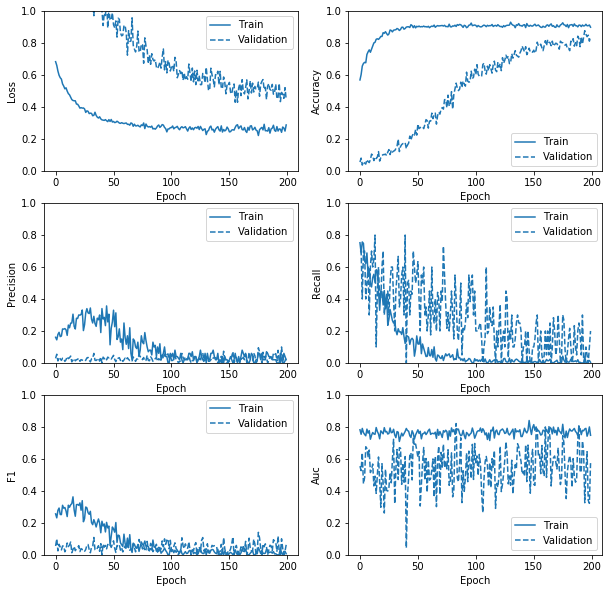

In [25]:
plt.figure(figsize=(10,10))
plot_metrics(up2_history)

### Train with UP3 (1:20)

In [26]:
# start = time.time()
# up3_history = model.fit_generator(up3_train_generator, 
#                               epochs=n_epochs, 
#                               steps_per_epoch=n_steps_per_epoch,
#                               validation_data=validation_generator,
#                               validation_steps=n_validation_steps,
#                               class_weight = [0.5, 1],
#                               callbacks=[reduce_lr]
#                              )
# end = time.time()

In [27]:
# print("Time taken:",end-start)

In [28]:
# plt.figure(figsize=(10,10))
# plot_metrics(up3_history)

### Train with Imbalanced original train data (1:40)

In [29]:
# start = time.time()
# imb_history = model.fit_generator(imb_train_generator,
#                                   epochs=n_epochs,
#                                   steps_per_epoch=n_steps_per_epoch,
#                                   validation_data=validation_generator,
#                                   validation_steps=n_validation_steps,
#                                   class_weight = [0.5, 2],
#                                   callbacks=[reduce_lr]
#                                  )
# end = time.time()

In [30]:
# print("Time taken:",end-start)

In [31]:
# plt.figure(figsize=(10,10))
# plot_metrics(imb_history)

## Evaluation

In [32]:
results_tr = model.evaluate(imb_train_generator,steps=100)
results_vl = model.evaluate(validation_generator,steps=100)

100/100 [==============================] - 20s 197ms/step


In [33]:
print("NAME :\tTRAIN :\tVALIDATION ")
for name, value_tr, value_vl in zip(model.metrics_names, results_tr, results_vl):
    print("%s : %5.3f : %7.3f" %(name, value_tr , value_vl))

# without classweights:
# NAME :	TRAIN :	VALIDATION 
# loss : 0.754 :   0.465
# Accuracy : 0.531 :   0.866
# Precision : 0.006 :   0.006
# Recall : 0.070 :   0.040
# F1 : 0.011 :   0.010
# AUC : 0.565 :   0.544

NAME :	TRAIN :	VALIDATION 
loss : 0.571 :   0.433
Accuracy : 0.683 :   0.821
Precision : 0.034 :   0.028
Recall : 0.240 :   0.137
F1 : 0.058 :   0.045
AUC : 0.611 :   0.533


## Prediction
The output of a binary classification is the probability of a sample belonging to a class.

In [34]:
# PREDICTED LABELS
start = time.time()
pred_tr = model.predict(imb_train_generator)
tr_end = time.time()
pred_vl = model.predict(validation_generator)
vl_end = time.time()

tr_end-start , vl_end-tr_end

(1223.8910028934479, 137.05424761772156)

In [35]:
# np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newtr.npy', pred_tr)
# np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newvl.npy', pred_vl)

In [36]:
# val_class = []
# for i, predicted in enumerate(pred_vl):
#     if predicted[0] > 0.1:
#         #assign i to class 1
#         val_class.append(1)
#     else:
#         #assign i to class 0
#         val_class.append(0)

In [37]:
# TRUE LABELS

train_labels = valid_traindf_names[Class].tolist()
train_labels = [int(i) for i in train_labels]

val_labels = valid_valdf_names[Class].tolist()
val_labels = [int(i) for i in val_labels]


### ROC Curve

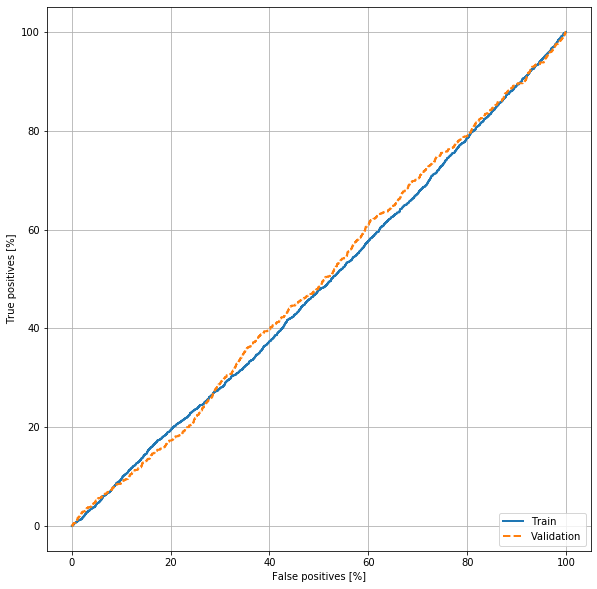

In [38]:
plt.figure(figsize=(10,10))
plot_roc("Train", train_labels, pred_tr, color=colors[0])
plot_roc("Validation", val_labels, pred_vl, color=colors[1],linestyle='--')
# plot_roc("Validation", val_labels, val_class, color=colors[3],linestyle='-.') # theshold 0.1
plt.legend(loc='lower right')

### Confusion matrix

Train data: 
TN: 68553 
FP: 30902 
FN: 1690 
TP: 689
Healthy Patients - correctly identified (True Negatives):  68553 0.6892866120355939
Healthy Patients - predicted to have glaucoma (False Positives):  30902 0.310713387964406
Glaucoma Patients - predicted healthy (False Negatives):  1690 0.7103825136612022
Glaucoma Patients - correctly identified (True Positives):  689 0.2896174863387978

Total Glaucoma patients:  2379 1.0
Total Healthy patients:  99455 1.0


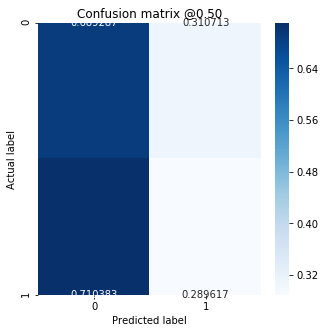

In [39]:
tn, fp, fn, tp = confusion_matrix(train_labels, pred_tr > 0.5).ravel()
train_cm = [tn, fp, fn, tp]
print("Train data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(train_labels, pred_tr)

Validation data: 
TN: 27951 
FP: 5183 
FN: 699 
TP: 110
Healthy Patients - correctly identified (True Negatives):  27951 0.8435745759642663
Healthy Patients - predicted to have glaucoma (False Positives):  5183 0.1564254240357337
Glaucoma Patients - predicted healthy (False Negatives):  699 0.8640296662546354
Glaucoma Patients - correctly identified (True Positives):  110 0.13597033374536466

Total Glaucoma patients:  809 1.0
Total Healthy patients:  33134 1.0


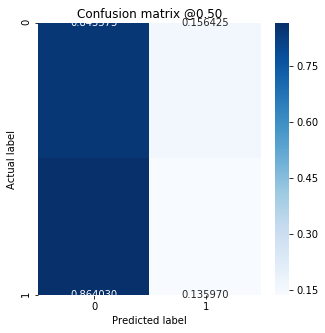

In [40]:
tn, fp, fn, tp = confusion_matrix(val_labels, pred_vl > 0.5).ravel()
val_cm = [tn, fp, fn, tp]
print("Validation data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(val_labels, pred_vl)

### MLFlow 

In [41]:
# history = up2_history
# tag_value = "trained twice bal and 1:10 with 84 tr layers - edited"

# exp_name = get_notebook_name()+"-run at-"+datetime.datetime.now().strftime("%d%b%Y %H:%M")
# keras_model_path = funduspath_CR+ exp_name + '_model'
# save_mlflow(keras_model_path,exp_name,which_gt,which_model,seq,BATCH_SIZE,
#             n_epochs,n_steps_per_epoch,n_validation_steps,
#             reg_value,learning_rate,decay,opt,
#             history,results_tr,results_vl,train_cm,val_cm
#            )

In [42]:
# client = MlflowClient()
# run = client.create_run('17')
# client.set_tag(run.info.run_id, "tag_key", tag_value)